# 🎭 Identity-Aware Text-Prompt Segmentation
## InsightFace + SAM 3 Native Text Prompt

**Concept:**  
ใส่ text prompt ธรรมดา เช่น `"wonyoung"` หรือ `"wonyoung shirt"` ระบบจะ:

1. **Parse prompt** — หาชื่อสมาชิก IVE ใน sentence
2. **InsightFace** — detect + identify สมาชิกในภาพ → ได้ face bbox
3. **ขยาย bbox** — face → body bounding box
4. **Crop ROI** — ตัดเฉพาะส่วนร่างกายออกมา
5. **SAM 3 Text Prompt** — segment ใน ROI ด้วย text:
   - `"wonyoung"` → SAM3 text: `"person"`
   - `"wonyoung shirt"` → SAM3 text: `"shirt"`
6. **Remap mask** — ใส่ mask กลับเข้าภาพเต็ม

**IVE Members:** `Wonyoung`, `Yujin`, `Gaeul`, `Liz`, `Leeseo`, `Rei`

---
## Section 1: Environment Setup 🔧

In [21]:
# =============================================================================
# CELL 1.1: Install Dependencies
# =============================================================================
import subprocess, sys

def pip(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=True)

# Core
pip("insightface")
pip("onnxruntime-gpu")
pip("opencv-python")
pip("Pillow")
pip("scipy")
pip("gradio")

# SAM 3 dependency fix
pip("setuptools<70")

print("✅ Dependencies installed!")

✅ Dependencies installed!


In [22]:
# =============================================================================
# CELL 1.2: Clone & Install SAM 3
# =============================================================================
import os

if not os.path.exists("sam3"):
    print("📥 Cloning SAM 3...")
    os.system("git clone https://github.com/facebookresearch/sam3.git")
    os.system(f'{sys.executable} -m pip install -q -e "sam3[notebooks]"')
    print("✅ SAM 3 installed!")
else:
    print("📁 SAM 3 already exists")
    # ติดตั้งใหม่ถ้ายังไม่ได้ install
    os.system(f'{sys.executable} -m pip install -q -e "sam3[notebooks]"')

📁 SAM 3 already exists


In [23]:
# =============================================================================
# CELL 1.3: HuggingFace Login (สำหรับ download SAM 3 weights)
# =============================================================================
from huggingface_hub import login

# ใส่ token ของคุณ หรือใช้ huggingface-cli login ก่อนรัน
login(token="YOUR_HF_TOKEN_HERE")

# ตรวจสอบ login status
try:
    from huggingface_hub import whoami
    user = whoami()
    print(f"✅ Logged in as: {user['name']}")
except Exception:
    print("⚠️  ยังไม่ได้ login HuggingFace — รัน: huggingface-cli login")

✅ Logged in as: Chanatamon


In [24]:
# =============================================================================
# CELL 1.4: GPU Check & Imports
# =============================================================================
import sys
import os

# เพิ่ม SAM 3 ใน path
SAM3_ROOT = os.path.abspath("sam3")
if SAM3_ROOT not in sys.path:
    sys.path.insert(0, SAM3_ROOT)

import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# Face Recognition
from insightface.app import FaceAnalysis

# SAM 3 Native API
from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import normalize_bbox

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("=" * 50)
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"   CUDA: {torch.version.cuda}")
else:
    print("⚠️  GPU ไม่พร้อมใช้งาน — ใช้ CPU (ช้ามาก)")
print(f"   Device: {DEVICE}")
print("=" * 50)

# RTX 6000 / Ampere+ optimization
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

✅ GPU: NVIDIA RTX 6000 Ada Generation
   VRAM: 50.9 GB
   CUDA: 12.4
   Device: cuda


---
## Section 2: InsightFace + Face Embedding Database 👤

In [25]:
# =============================================================================
# CELL 2.1: โหลด InsightFace + สร้าง Embedding Database
# =============================================================================

# Member mapping: folder name → display name
MEMBER_MAPPING = {
    "An_Yujin":      "Yujin",
    "Jang_Wonyoung": "Wonyoung",
    "Kim_Gaeul":     "Gaeul",
    "Kim_Jiwon":     "Liz",
    "Lee_Hyunseo":   "Leeseo",
    "Naoi_Rei":      "Rei",
}

IVE_MEMBERS = list(MEMBER_MAPPING.values())  # ['Yujin', 'Wonyoung', ...]
IVE_MEMBERS_LOWER = [m.lower() for m in IVE_MEMBERS]  # สำหรับ case-insensitive match

# โหลด InsightFace
print("🚀 Loading InsightFace buffalo_l...")
face_analyzer = FaceAnalysis(
    name="buffalo_l",
    root="./insightface_models",
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
)
face_analyzer.prepare(ctx_id=0, det_size=(640, 640))
print("✅ InsightFace loaded!")


def normalize_embedding(emb: np.ndarray) -> np.ndarray:
    norm = np.linalg.norm(emb)
    return emb / (norm + 1e-8)


def build_embedding_database(dataset_dir="Dataset", det_score_thresh=0.35):
    """สร้าง embedding DB จากรูปใน Dataset/"""
    embeddings_db = {}
    dataset_path = Path(dataset_dir)

    for folder_name, member_name in MEMBER_MAPPING.items():
        member_dir = dataset_path / folder_name
        if not member_dir.exists():
            print(f"  ⚠️  {folder_name}/ ไม่พบ")
            continue

        images = list(member_dir.glob("*.jpg")) + list(member_dir.glob("*.png"))
        embeddings = []

        for img_path in images:
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            faces = face_analyzer.get(img)
            faces = [f for f in faces if f.det_score >= det_score_thresh]
            if not faces:
                continue
            face = max(faces, key=lambda f: f.det_score)
            emb = face.normed_embedding if face.normed_embedding is not None else face.embedding
            embeddings.append(normalize_embedding(emb))

        if embeddings:
            avg_emb = normalize_embedding(np.mean(embeddings, axis=0))
            embeddings_db[member_name] = avg_emb
            print(f"  ✅ {member_name}: {len(embeddings)} faces")
        else:
            print(f"  ❌ {member_name}: ไม่พบ face")

    return embeddings_db


print("\n📚 Building embedding database...")
embeddings_db = build_embedding_database()
print(f"\n✅ Database ready: {list(embeddings_db.keys())}")

🚀 Loading InsightFace buffalo_l...
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: ./insightface_models/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvi

libpng warning: iCCP: known incorrect sRGB profile


  ✅ Leeseo: 24 faces
  ✅ Rei: 17 faces

✅ Database ready: ['Yujin', 'Wonyoung', 'Gaeul', 'Liz', 'Leeseo', 'Rei']


---
## Section 3: SAM 3 Native Model 🤖

In [26]:
# =============================================================================
# CELL 3.1: โหลด SAM 3 (Native HuggingFace weights)
# =============================================================================
import sam3 as _sam3_pkg

# bpe_path สำหรับ text tokenizer
BPE_PATH = os.path.join(os.path.dirname(_sam3_pkg.__file__), "assets", "bpe_simple_vocab_16e6.txt.gz")

print("📦 Loading SAM 3 model (จะ download weights ครั้งแรก ~5GB)...")
print("   Please wait...")

# ใช้ bfloat16 สำหรับ Ampere GPU
with torch.autocast("cuda", dtype=torch.bfloat16):
    sam3_model = build_sam3_image_model(
        bpe_path=BPE_PATH,
        device=DEVICE,
        eval_mode=True,
        load_from_HF=True,
    )

# Sam3Processor: wrapper สำหรับ inference
sam3_processor = Sam3Processor(
    model=sam3_model,
    device=DEVICE,
    confidence_threshold=0.4,
)

print("✅ SAM 3 loaded!")

📦 Loading SAM 3 model (จะ download weights ครั้งแรก ~5GB)...
   Please wait...
✅ SAM 3 loaded!


---
## Section 4: Prompt Parser 📝

แยก **ชื่อสมาชิก** กับ **SAM 3 text prompt** จาก user input:

| Input prompt | Member | SAM 3 text |
|---|---|---|
| `"wonyoung"` | Wonyoung | `"person"` |
| `"wonyoung shirt"` | Wonyoung | `"shirt"` |
| `"yujin's hair"` | Yujin | `"hair"` |
| `"liz dress"` | Liz | `"dress"` |
| `"shirt"` | None | `"shirt"` |


In [27]:
# =============================================================================
# CELL 4.1: Prompt Parser
# =============================================================================
import re
from typing import Optional, Tuple


def parse_prompt(prompt: str) -> Tuple[Optional[str], str]:
    """
    แยก member name และ SAM 3 text prompt จาก user input

    Returns:
        (member_name, sam3_text_prompt)
        member_name: ชื่อสมาชิก (canonical) หรือ None ถ้าไม่พบ
        sam3_text_prompt: text สำหรับส่งเข้า SAM 3

    Examples:
        "wonyoung"       → ("Wonyoung", "person")
        "wonyoung shirt" → ("Wonyoung", "shirt")
        "yujin's hair"   → ("Yujin", "hair")
        "shirt"          → (None, "shirt")
    """
    text = prompt.strip().lower()

    found_member = None
    remaining = text

    for member in IVE_MEMBERS:
        member_lower = member.lower()
        # match ชื่อสมาชิก (word boundary)
        pattern = r"\b" + re.escape(member_lower) + r"\b"
        if re.search(pattern, text):
            found_member = member
            # ลบชื่อสมาชิกออกจาก text พร้อม possessive ('s)
            remaining = re.sub(pattern + r"'?s?", "", text).strip()
            # ลบ connector words
            remaining = re.sub(r"\b(the|a|an|of|with|and|'s)\b", "", remaining).strip()
            remaining = re.sub(r"\s+", " ", remaining).strip()
            break

    if found_member is None:
        # ไม่พบสมาชิก — ใช้ prompt ทั้งหมดเป็น SAM3 text
        return None, text if text else "person"

    if not remaining:
        # พบแค่ชื่อสมาชิก ไม่มี object → segment ทั้งคน
        sam3_text = "person"
    else:
        sam3_text = remaining

    return found_member, sam3_text


# ทดสอบ
test_cases = [
    "wonyoung",
    "Wonyoung shirt",
    "yujin's hair",
    "liz dress",
    "Leeseo shoes",
    "REI jacket",
    "shirt",
    "gaeul face",
]

print("Prompt Parser Test:")
print("-" * 50)
for t in test_cases:
    member, sam3_text = parse_prompt(t)
    print(f"  '{t}' → member={member}, SAM3='{sam3_text}'")

Prompt Parser Test:
--------------------------------------------------
  'wonyoung' → member=Wonyoung, SAM3='person'
  'Wonyoung shirt' → member=Wonyoung, SAM3='shirt'
  'yujin's hair' → member=Yujin, SAM3='hair'
  'liz dress' → member=Liz, SAM3='dress'
  'Leeseo shoes' → member=Leeseo, SAM3='shoes'
  'REI jacket' → member=Rei, SAM3='jacket'
  'shirt' → member=None, SAM3='shirt'
  'gaeul face' → member=Gaeul, SAM3='face'


---
## Section 5: Pipeline Functions 🔗

In [28]:
# =============================================================================
# CELL 5.1: Helper Functions
# =============================================================================
from scipy.optimize import linear_sum_assignment


def find_best_match(embedding: np.ndarray, threshold: float = 0.42) -> Tuple[str, float]:
    """หา member ที่ embedding ตรงที่สุด (cosine similarity บน L2-normalized vectors)"""
    best_name = "Unknown"
    best_score = -1.0
    for name, ref_emb in embeddings_db.items():
        score = float(np.dot(embedding, ref_emb))
        if score > best_score:
            best_score = score
            best_name = name
    if best_score < threshold:
        best_name = "Unknown"
    return best_name, best_score


def face_to_body_bbox(
    face_bbox: np.ndarray,
    img_shape: Tuple[int, int],
    width_scale: float = 3.0,
    height_top_scale: float = 1.2,
    height_bottom_scale: float = 5.0,
) -> np.ndarray:
    """
    ขยาย face bounding box ให้ครอบคลุมร่างกาย

    Args:
        face_bbox: [x1, y1, x2, y2] pixel coordinates
        img_shape: (height, width)
        width_scale: ขยายความกว้างจาก face_width × scale
        height_top_scale: ขยายขึ้นด้านบนจาก center × face_height
        height_bottom_scale: ขยายลงด้านล่างจาก center × face_height

    Returns:
        body_bbox: [x1, y1, x2, y2] clipped to image bounds
    """
    x1, y1, x2, y2 = face_bbox.astype(float)
    cx = (x1 + x2) / 2.0
    cy = (y1 + y2) / 2.0
    fw = x2 - x1
    fh = y2 - y1

    img_h, img_w = img_shape

    half_bw = (fw * width_scale) / 2.0
    bx1 = int(max(0, cx - half_bw))
    bx2 = int(min(img_w - 1, cx + half_bw))
    by1 = int(max(0, cy - fh * height_top_scale))
    by2 = int(min(img_h - 1, cy + fh * height_bottom_scale))

    return np.array([bx1, by1, bx2, by2], dtype=np.int32)


def detect_and_identify_members(image_bgr: np.ndarray, threshold: float = 0.42):
    """
    Detect faces ทุกคนในภาพ แล้วระบุตัวตน

    Returns:
        list of dicts: [{'name', 'face_bbox', 'body_bbox', 'similarity', 'embedding'}]
    """
    faces = face_analyzer.get(image_bgr)
    faces = [f for f in faces if f.det_score >= 0.40]

    if not faces:
        return []

    img_h, img_w = image_bgr.shape[:2]
    results = []

    for face in faces:
        emb = face.normed_embedding if face.normed_embedding is not None else face.embedding
        emb = normalize_embedding(emb)
        name, sim = find_best_match(emb, threshold=threshold)

        face_bbox = face.bbox.astype(int)
        body_bbox = face_to_body_bbox(face_bbox, (img_h, img_w))

        results.append({
            "name": name,
            "face_bbox": face_bbox,
            "body_bbox": body_bbox,
            "similarity": sim,
            "det_score": float(face.det_score),
            "embedding": emb,
        })

    return results


print("✅ Helper functions defined")

✅ Helper functions defined


In [29]:
# =============================================================================
# CELL 5.2: SAM 3 Text-Prompt Segmentation on ROI (Improved)
# =============================================================================

# ตีกรอบ ROI ให้เหมาะกับ body part เพื่อลด interference จากคนข้างๆ
PROMPT_ROI_REGION = {
    "hair":   (0.00, 0.00, 1.00, 1.00),  # top 38% (หัว/บ่า)
    "face":   (0.00, 0.00, 1.00, 1.00),  # top 32%
    "head":   (0.00, 0.00, 1.00, 1.00),
    "shirt":  (0.00, 0.00, 1.00, 1.00),  # กลางตัว
    "top":    (0.00, 0.00, 1.00, 1.00),
    "dress":  (0.00, 0.00, 1.00, 1.00),
    "jacket": (0.00, 0.00, 1.00, 1.00),
    "coat":   (0.00, 0.00, 1.00, 1.00),
    "pants":  (0.00, 0.00, 1.00, 1.00),  # ขาล่าง
    "skirt":  (0.00, 0.00, 1.00, 1.00),
    "shoes":  (0.00, 0.00, 1.00, 1.00),  # ล่างสุด
    "boots":  (0.00, 0.00, 1.00, 1.00),
    "person": (0.00, 0.00, 1.00, 1.00),  # ทั้งตัว
}


def get_adjusted_bbox(body_bbox: np.ndarray, text_prompt: str) -> np.ndarray:
    """
    ปรับ body_bbox ให้เหมาะกับ body part ที่ต้องการ segment
    ลดการ overlap กับคนข้างๆ และ segment เฉพาะส่วนที่เกี่ยวข้อง
    """
    x1, y1, x2, y2 = body_bbox
    bw = x2 - x1
    bh = y2 - y1

    # หา region สำหรับ prompt นี้
    key = text_prompt.lower().strip()
    region = PROMPT_ROI_REGION.get(key, PROMPT_ROI_REGION["person"])
    rx1, ry1, rx2, ry2 = region

    ax1 = int(x1 + bw * rx1)
    ay1 = int(y1 + bh * ry1)
    ax2 = int(x1 + bw * rx2)
    ay2 = int(y1 + bh * ry2)

    return np.array([ax1, ay1, ax2, ay2], dtype=np.int32)


@torch.inference_mode()
def segment_roi_with_text(
    image_rgb: np.ndarray,
    body_bbox: np.ndarray,
    text_prompt: str,
    confidence_threshold: float = 0.35,
    bbox_expand: float = 1.0,
) -> np.ndarray:
    """
    Segment ด้วย SAM 3 text prompt โดย crop เฉพาะ ROI (body bbox)

    Improvements:
    1. Prompt-specific ROI: ตัด ROI ให้เหมาะกับ body part (hair → แค่ช่วงหัว)
    2. Spatial centroid scoring: เลือก mask ที่ centroid ใกล้ center ROI
       ป้องกัน segment ผมหรือเสื้อของคนข้างๆ ใน group photo
    3. Combined score = SAM confidence + proximity + inner-overlap

    Args:
        image_rgb: full image RGB (H, W, 3)
        body_bbox: [x1, y1, x2, y2] body region จาก InsightFace
        text_prompt: "person", "hair", "shirt", etc.
        confidence_threshold: SAM 3 confidence cutoff

    Returns:
        full_mask: binary mask (H, W) uint8 ใน original image coords
    """
    img_h, img_w = image_rgb.shape[:2]

    # ── 1. ปรับ ROI ให้เหมาะกับ body part ──────────────────────────────────
    adj_bbox = get_adjusted_bbox(body_bbox, text_prompt)
    x1, y1, x2, y2 = adj_bbox
    # ── Expand bbox รอบด้าน (default 1.0 = ไม่ขยาย) ──────────────────────
    if bbox_expand != 1.0:
        bw = x2 - x1
        bh = y2 - y1
        cx = (x1 + x2) / 2.0
        cy = (y1 + y2) / 2.0
        new_bw = bw * bbox_expand
        new_bh = bh * bbox_expand
        x1 = int(max(0, cx - new_bw / 2))
        y1 = int(max(0, cy - new_bh / 2))
        x2 = int(min(img_w - 1, cx + new_bw / 2))
        y2 = int(min(img_h - 1, cy + new_bh / 2))
        adj_bbox = np.array([x1, y1, x2, y2], dtype=np.int32)

    if x2 - x1 < 10 or y2 - y1 < 10:
        return np.zeros((img_h, img_w), dtype=np.uint8)

    # ── 2. Crop ROI ──────────────────────────────────────────────────────────
    roi_rgb = image_rgb[y1:y2, x1:x2]
    roi_pil = Image.fromarray(roi_rgb)
    roi_h, roi_w = roi_rgb.shape[:2]

    # ── 3. SAM 3 inference ──────────────────────────────────────────────────
    sam3_processor.confidence_threshold = confidence_threshold

    with torch.autocast(DEVICE, dtype=torch.bfloat16):
        state = sam3_processor.set_image(roi_pil)
        state = sam3_processor.set_text_prompt(text_prompt, state)

    if "masks" not in state or state["masks"] is None or len(state["masks"]) == 0:
        print(f"  ⚠️  SAM3: ไม่พบ mask สำหรับ \"{text_prompt}\" — fallback to body bbox")
        full_mask = np.zeros((img_h, img_w), dtype=np.uint8)
        full_mask[y1:y2, x1:x2] = 1
        return full_mask

    masks  = state["masks"]   # (N, 1, roi_h, roi_w) bool tensor
    scores = state["scores"]  # (N,)

    # ── 4. Spatial-aware mask selection ─────────────────────────────────────
    # เป้าหมาย: เลือก mask ที่ centroid อยู่ใกล้ center ของ ROI
    # (คนข้างๆ จะอยู่ขอบ ROI — centroid ของ mask จะอยู่ไกลจาก center)
    roi_cx = roi_w * 0.5
    roi_cy = roi_h * 0.45   # ขยับขึ้นนิดเพราะหัวอยู่บนกว่าตรงกลาง

    # Inner zone: 50% center ของ ROI — mask ที่อยู่ใน zone นี้ได้คะแนนโบนัส
    iz_x1 = int(roi_w * 0.20)
    iz_y1 = int(roi_h * 0.05)
    iz_x2 = int(roi_w * 0.80)
    iz_y2 = int(roi_h * 0.90)

    best_mask_np = None
    best_combined = -1.0
    best_score_info = {}

    for i in range(len(masks)):
        mask_np = masks[i, 0].cpu().numpy().astype(bool)
        sam_score = float(scores[i])

        ys, xs = np.where(mask_np)
        if len(xs) == 0:
            continue

        # Centroid
        cx, cy = xs.mean(), ys.mean()

        # Proximity: distance ของ centroid จาก ROI center (normalized 0–1, สูง = ใกล้)
        dist_norm = np.sqrt(((cx - roi_cx) / roi_w) ** 2 + ((cy - roi_cy) / roi_h) ** 2)
        proximity = 1.0 / (1.0 + dist_norm * 4.0)

        # Inner overlap: สัดส่วน pixel ของ mask ที่อยู่ใน inner zone
        inner_zone = np.zeros_like(mask_np)
        inner_zone[iz_y1:iz_y2, iz_x1:iz_x2] = True
        overlap_ratio = float((mask_np & inner_zone).sum()) / (mask_np.sum() + 1e-6)

        # Combined score — ให้น้ำหนัก proximity และ overlap มากกว่า SAM confidence
        # เพราะ SAM confidence สูงไม่ได้แปลว่าเป็นคนที่ถูกต้อง
        combined = sam_score * 0.30 + proximity * 0.45 + overlap_ratio * 0.25

        if combined > best_combined:
            best_combined = combined
            best_mask_np  = mask_np.astype(np.uint8)
            best_score_info = {
                "sam": sam_score, "proximity": proximity,
                "overlap": overlap_ratio, "combined": combined,
                "centroid": (cx, cy),
            }

    if best_mask_np is None:
        print(f"  ⚠️  SAM3: ไม่มี valid mask — fallback")
        full_mask = np.zeros((img_h, img_w), dtype=np.uint8)
        full_mask[y1:y2, x1:x2] = 1
        return full_mask

    # ── 5. Remap mask กลับ full image ────────────────────────────────────────
    full_mask = np.zeros((img_h, img_w), dtype=np.uint8)
    if best_mask_np.shape != (roi_h, roi_w):
        best_mask_np = cv2.resize(best_mask_np, (roi_w, roi_h), interpolation=cv2.INTER_NEAREST)
    full_mask[y1:y2, x1:x2] = best_mask_np

    si = best_score_info
    print(f"  ✅ SAM3: \"{text_prompt}\" adj_bbox={adj_bbox.tolist()}")
    print(f"     score={si['sam']:.3f} | proximity={si['proximity']:.3f} "
          f"| overlap={si['overlap']:.3f} | combined={si['combined']:.3f}")
    print(f"     centroid=({si['centroid'][0]:.0f},{si['centroid'][1]:.0f}) "
          f"roi_center=({roi_cx:.0f},{roi_cy:.0f}) pixels={int(full_mask.sum())}")

    return full_mask


print("✅ segment_roi_with_text (improved) defined")
print("   - Prompt-specific ROI adjustment (hair/shirt/shoes/...)")
print("   - Spatial centroid scoring (proximity + inner-overlap)")


✅ segment_roi_with_text (improved) defined
   - Prompt-specific ROI adjustment (hair/shirt/shoes/...)
   - Spatial centroid scoring (proximity + inner-overlap)


In [30]:
# =============================================================================
# CELL 5.3: Main Pipeline — segment_from_prompt()
# =============================================================================


def segment_from_prompt(
    image_bgr: np.ndarray,
    prompt: str,
    similarity_threshold: float = 0.42,
    confidence_threshold: float = 0.35,
    width_scale: float = 3.0,
    height_top_scale: float = 1.2,
    height_bottom_scale: float = 5.0,
    bbox_expand: float = 1.0,
):
    """
    🔥 Main Pipeline: ใส่ prompt ธรรมดา → ได้ segmentation result

    Flow:
        prompt → parse → InsightFace identify → body_bbox → SAM3 text → mask

    Args:
        image_bgr: input image (BGR)
        prompt: natural language เช่น "wonyoung", "yujin shirt", "liz hair"
        similarity_threshold: InsightFace recognition threshold
        confidence_threshold: SAM 3 mask confidence threshold

    Returns:
        dict with keys:
            'overlay'     : image_rgb with colored mask overlay
            'cutout'      : RGBA image (person cutout, transparent background)
            'annotated'   : image with bbox + label
            'mask'        : binary mask (H, W) uint8
            'member'      : detected member name (or None)
            'sam3_text'   : text prompt used for SAM 3
            'status'      : human-readable status string
            'face_bbox'   : face bbox [x1,y1,x2,y2] (or None)
            'body_bbox'   : body bbox [x1,y1,x2,y2] (or None)
    """
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    img_h, img_w = image_bgr.shape[:2]

    # Step 1: Parse prompt
    member_name, sam3_text = parse_prompt(prompt)
    print(f"\n🔍 Prompt: '{prompt}'")
    print(f"   → member={member_name}, SAM3 text='{sam3_text}'")

    # Step 2: InsightFace — ถ้ามีชื่อสมาชิก
    body_bbox = None
    face_bbox = None

    if member_name is not None:
        if member_name not in embeddings_db:
            return {
                "overlay": image_rgb, "cutout": None, "annotated": image_rgb,
                "mask": None, "member": member_name, "sam3_text": sam3_text,
                "status": f"❌ ไม่พบ embedding ของ {member_name}",
                "face_bbox": None, "body_bbox": None,
            }

        # Detect faces
        detections = detect_and_identify_members(image_bgr, threshold=similarity_threshold)

        # หา target member
        target = None
        for det in detections:
            if det["name"] == member_name:
                target = det
                break

        if target is None:
            # ลอง threshold ต่ำลงหน่อย
            detections_loose = detect_and_identify_members(
                image_bgr, threshold=similarity_threshold * 0.85
            )
            for det in detections_loose:
                if det["name"] == member_name:
                    target = det
                    break

        if target is None:
            all_found = [d["name"] for d in detections]
            return {
                "overlay": image_rgb, "cutout": None, "annotated": image_rgb,
                "mask": None, "member": member_name, "sam3_text": sam3_text,
                "status": f"❌ ไม่พบ {member_name} ในภาพ (detected: {all_found})",
                "face_bbox": None, "body_bbox": None,
            }

        face_bbox = target["face_bbox"]
        body_bbox = face_to_body_bbox(
            face_bbox, (img_h, img_w),
            width_scale=width_scale,
            height_top_scale=height_top_scale,
            height_bottom_scale=height_bottom_scale,
        )
        similarity = target["similarity"]
        print(f"   → Found {member_name} (sim={similarity:.3f})")
        print(f"   → body_bbox={body_bbox.tolist()}")

    else:
        # ไม่มีชื่อสมาชิก → segment ทั้งภาพด้วย text prompt
        body_bbox = np.array([0, 0, img_w - 1, img_h - 1], dtype=np.int32)
        similarity = None
        print("   → ไม่พบชื่อสมาชิก: segment ทั้งภาพ")

    # Step 3: SAM 3 text prompt บน body ROI
    mask = segment_roi_with_text(
        image_rgb, body_bbox, sam3_text,
        confidence_threshold=confidence_threshold,
        bbox_expand=bbox_expand,
    )

    # Step 4: สร้าง output images
    overlay = create_overlay(image_rgb, mask)
    cutout = create_cutout(image_rgb, mask)
    annotated = create_annotated(
        image_rgb, face_bbox, body_bbox, member_name,
        similarity, sam3_text
    )

    sim_str = f", sim={similarity:.3f}" if similarity is not None else ""
    status = f"✅ member={member_name} | SAM3='{sam3_text}'{sim_str} | pixels={int(mask.sum())}"

    return {
        "overlay":   overlay,
        "cutout":    cutout,
        "annotated": annotated,
        "mask":      mask,
        "member":    member_name,
        "sam3_text": sam3_text,
        "status":    status,
        "face_bbox": face_bbox,
        "body_bbox": body_bbox,
    }


print("✅ segment_from_prompt defined")

✅ segment_from_prompt defined


In [31]:
# =============================================================================
# CELL 5.4: Visualization Helpers
# =============================================================================

# สีประจำสมาชิก (RGB)
MEMBER_COLORS = {
    "Wonyoung": (255, 100, 150),
    "Yujin":    (100, 200, 255),
    "Gaeul":    (150, 255, 100),
    "Liz":      (255, 200, 50),
    "Leeseo":   (200, 100, 255),
    "Rei":      (100, 255, 200),
    "Unknown":  (200, 200, 200),
}


def create_overlay(
    image_rgb: np.ndarray,
    mask: np.ndarray,
    color: Tuple = (255, 100, 50),
    alpha: float = 0.5,
) -> np.ndarray:
    """ทับ mask overlay บนภาพต้นฉบับ"""
    overlay = image_rgb.copy().astype(np.float32)
    color_arr = np.array(color, dtype=np.float32)
    overlay[mask > 0] = (
        overlay[mask > 0] * (1 - alpha) + color_arr * alpha
    )
    return np.clip(overlay, 0, 255).astype(np.uint8)


def create_cutout(image_rgb: np.ndarray, mask: np.ndarray) -> np.ndarray:
    """สร้าง RGBA cutout (background โปร่งใส)"""
    rgba = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2RGBA)
    rgba[:, :, 3] = (mask * 255).astype(np.uint8)
    return rgba


def create_annotated(
    image_rgb: np.ndarray,
    face_bbox,
    body_bbox,
    member_name: Optional[str],
    similarity: Optional[float],
    sam3_text: str,
) -> np.ndarray:
    """วาด bbox + label บนภาพ"""
    annotated = image_rgb.copy()
    color_rgb = MEMBER_COLORS.get(member_name, MEMBER_COLORS["Unknown"])
    color_bgr = color_rgb[::-1]  # OpenCV ใช้ BGR

    # วาด body bbox
    if body_bbox is not None:
        bx1, by1, bx2, by2 = body_bbox
        cv2.rectangle(annotated, (bx1, by1), (bx2, by2), color_bgr, 3)

    # วาด face bbox
    if face_bbox is not None:
        fx1, fy1, fx2, fy2 = face_bbox
        cv2.rectangle(annotated, (fx1, fy1), (fx2, fy2), (255, 255, 0), 2)

    # Label
    label = member_name or "Unknown"
    if similarity is not None:
        label += f" ({similarity:.2f})"
    label += f" | '{sam3_text}'"

    if body_bbox is not None:
        bx1, by1 = body_bbox[0], body_bbox[1]
        # Background rectangle สำหรับ text
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(
            annotated,
            (bx1, max(0, by1 - th - 8)),
            (bx1 + tw + 4, by1),
            color_bgr, -1
        )
        cv2.putText(
            annotated, label,
            (bx1 + 2, max(th, by1 - 4)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2
        )

    return annotated


def show_results(result: dict, figsize=(18, 6)):
    """แสดงผลลัพธ์ทั้ง 3 แบบ: Annotated, Overlay, Cutout"""
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    titles = ["Annotated (BBox)", "Overlay (Mask)", "Cutout (RGBA)"]
    images = [
        result.get("annotated"),
        result.get("overlay"),
        result.get("cutout"),
    ]

    for ax, title, img in zip(axes, titles, images):
        ax.set_title(title, fontsize=13, fontweight="bold")
        if img is not None:
            # RGBA → show with white background
            if img.shape[-1] == 4:
                bg = np.ones_like(img[:, :, :3]) * 255
                alpha_ch = img[:, :, 3:4] / 255.0
                disp = (img[:, :, :3] * alpha_ch + bg * (1 - alpha_ch)).astype(np.uint8)
                ax.imshow(disp)
            else:
                ax.imshow(img)
        ax.axis("off")

    plt.suptitle(result.get("status", ""), fontsize=11, y=1.02)
    plt.tight_layout()
    plt.show()


print("✅ Visualization helpers defined")

✅ Visualization helpers defined


---
## Section 6: Gradio Web UI 🎨

**วิธีใช้งาน:**
- อัปโหลดภาพ
- ใส่ prompt เช่น `wonyoung`, `yujin shirt`, `liz hair`
- กด **Segment** → ได้ผลลัพธ์ 3 แบบ

In [32]:
# =============================================================================
# CELL 6.1: Gradio UI
# =============================================================================
import gradio as gr


def gradio_segment(input_image, prompt, sim_thresh, conf_thresh):
    """Gradio callback"""
    if input_image is None:
        return None, None, None, "⚠️ กรุณาอัปโหลดภาพ"
    if not prompt.strip():
        return None, None, None, "⚠️ กรุณาใส่ prompt"

    # Gradio ส่งภาพมาเป็น RGB numpy array
    image_bgr = cv2.cvtColor(np.array(input_image), cv2.COLOR_RGB2BGR)

    result = segment_from_prompt(
        image_bgr=image_bgr,
        prompt=prompt,
        similarity_threshold=sim_thresh,
        confidence_threshold=conf_thresh,
        bbox_expand=1.3,
    )

    annotated = result.get("annotated")
    overlay   = result.get("overlay")
    cutout    = result.get("cutout")
    status    = result.get("status", "")

    # cutout RGBA → RGB for display (white bg)
    if cutout is not None and cutout.shape[-1] == 4:
        bg = np.ones_like(cutout[:, :, :3]) * 255
        a = cutout[:, :, 3:4] / 255.0
        cutout_disp = (cutout[:, :, :3] * a + bg * (1 - a)).astype(np.uint8)
    else:
        cutout_disp = cutout

    return annotated, overlay, cutout_disp, status


def gradio_identify_all(input_image, sim_thresh):
    """Identify ทุกคนในภาพพร้อม similarity score"""
    if input_image is None:
        return None, "⚠️ กรุณาอัปโหลดภาพ"

    image_bgr = cv2.cvtColor(np.array(input_image), cv2.COLOR_RGB2BGR)
    detections = detect_and_identify_members(image_bgr, threshold=0.30)  # threshold ต่ำเพื่อ show ทุกคน

    if not detections:
        return input_image, "❌ ไม่พบใบหน้าในภาพ"

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    annotated = image_rgb.copy()

    info_lines = []
    for det in sorted(detections, key=lambda x: x["similarity"], reverse=True):
        name = det["name"]
        sim  = det["similarity"]
        color_rgb = MEMBER_COLORS.get(name, MEMBER_COLORS["Unknown"])
        color_bgr = color_rgb[::-1]

        # Face bbox
        fx1, fy1, fx2, fy2 = det["face_bbox"]
        cv2.rectangle(annotated, (fx1, fy1), (fx2, fy2), color_bgr, 3)

        # Body bbox
        bx1, by1, bx2, by2 = det["body_bbox"]
        cv2.rectangle(annotated, (bx1, by1), (bx2, by2), color_bgr, 2)

        label = f"{name} ({sim:.2f})"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.65, 2)
        cv2.rectangle(annotated, (fx1, max(0, fy1 - th - 8)), (fx1 + tw + 4, fy1), color_bgr, -1)
        cv2.putText(annotated, label, (fx1 + 2, max(th, fy1 - 4)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)

        status_icon = "✅" if sim >= sim_thresh else "⚠️"
        info_lines.append(f"{status_icon} {name}: {sim:.3f}")

    return annotated, "\n".join(info_lines)


# Build UI
PROMPT_EXAMPLES = [
    ["wonyoung"],
    ["wonyoung shirt"],
    ["yujin hair"],
    ["liz dress"],
    ["leeseo shoes"],
    ["rei jacket"],
    ["gaeul face"],
]

with gr.Blocks(title="IVE Identity-Aware Text Segmentation") as demo:
    gr.Markdown("""
    # 🎭 IVE Identity-Aware Text Segmentation
    **InsightFace** → detect member → body bbox → **SAM 3** text prompt → segment

    **Prompt examples:** `wonyoung` · `yujin shirt` · `liz hair` · `rei jacket`
    """)

    with gr.Tab("✂️ Segment by Prompt"):
        with gr.Row():
            with gr.Column(scale=1):
                img_input = gr.Image(label="Input Image", type="numpy")
                prompt_input = gr.Textbox(
                    label="Text Prompt",
                    placeholder="เช่น: wonyoung, yujin shirt, liz hair ...",
                )
                with gr.Accordion("Advanced Settings", open=False):
                    sim_thresh = gr.Slider(
                        0.30, 0.70, value=0.42, step=0.01,
                        label="InsightFace Similarity Threshold"
                    )
                    conf_thresh = gr.Slider(
                        0.20, 0.70, value=0.35, step=0.01,
                        label="SAM 3 Confidence Threshold"
                    )
                btn_segment = gr.Button("🔍 Segment", variant="primary")
                gr.Examples(examples=PROMPT_EXAMPLES, inputs=prompt_input)

            with gr.Column(scale=2):
                with gr.Row():
                    out_annotated = gr.Image(label="Annotated (BBox)", type="numpy")
                    out_overlay   = gr.Image(label="Overlay (Mask)", type="numpy")
                    out_cutout    = gr.Image(label="Cutout", type="numpy")
                out_status = gr.Textbox(label="Status", interactive=False)

        btn_segment.click(
            fn=gradio_segment,
            inputs=[img_input, prompt_input, sim_thresh, conf_thresh],
            outputs=[out_annotated, out_overlay, out_cutout, out_status],
        )

    with gr.Tab("👥 Identify All Members"):
        with gr.Row():
            with gr.Column(scale=1):
                img_input2 = gr.Image(label="Input Image", type="numpy")
                sim_thresh2 = gr.Slider(
                    0.30, 0.70, value=0.42, step=0.01,
                    label="Recognition Threshold"
                )
                btn_identify = gr.Button("🔍 Identify All", variant="primary")
            with gr.Column(scale=2):
                out_annotated2 = gr.Image(label="Detected Members", type="numpy")
                out_info       = gr.Textbox(label="Members Found", interactive=False, lines=8)

        btn_identify.click(
            fn=gradio_identify_all,
            inputs=[img_input2, sim_thresh2],
            outputs=[out_annotated2, out_info],
        )

print("✅ Gradio UI built — รันเซลล์ถัดไปเพื่อ launch")

✅ Gradio UI built — รันเซลล์ถัดไปเพื่อ launch


In [33]:
# Launch UI
demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://6b5ea4e4a60b010ca2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---
## Section 7: Quick Test 🧪

ทดสอบ pipeline โดยตรง (ไม่ต้องผ่าน Gradio)

✅ Loaded image: (1266, 2481, 3)

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.663)
   → body_bbox=[394, 46, 880, 1265]
  ✅ SAM3: "person" adj_bbox=[394, 46, 880, 1265]
     score=0.836 | proximity=0.846 | overlap=0.766 | combined=0.823
     centroid=(232,596) roi_center=(243,549) pixels=316948


/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4



✅ member=Wonyoung | SAM3='person', sim=0.663 | pixels=316948


/tmp/ipykernel_20414/1679451358.py:112: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


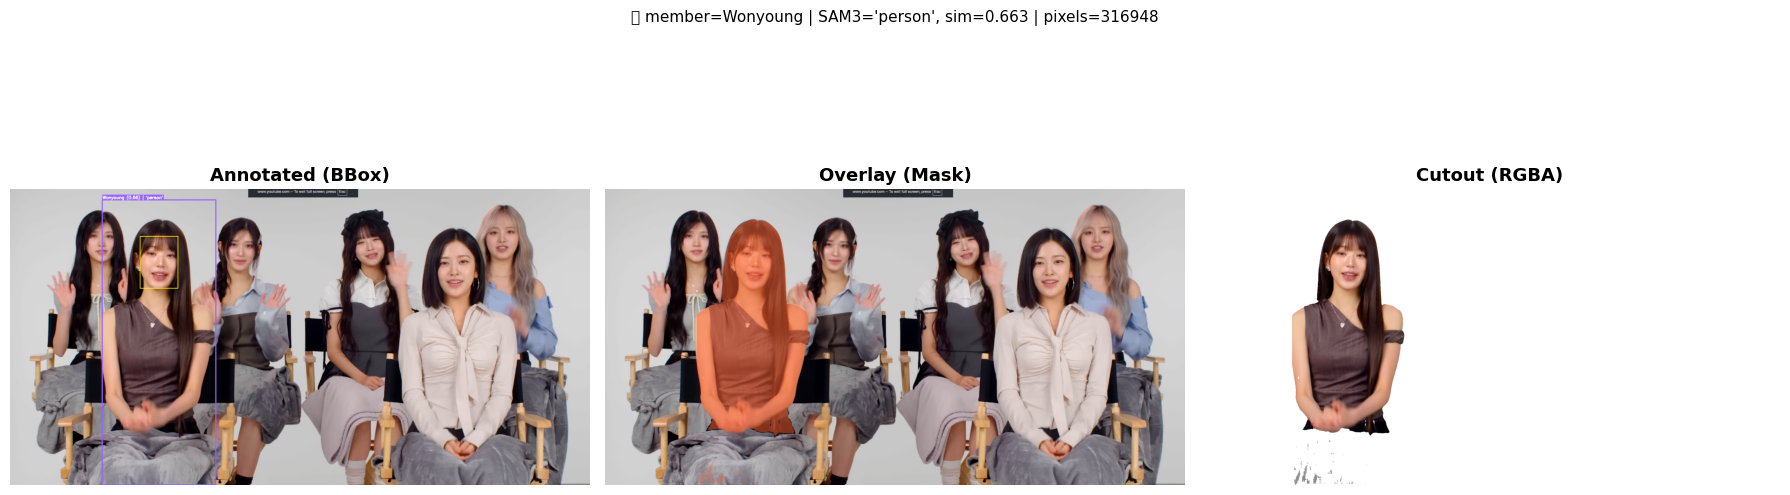

In [34]:
# =============================================================================
# CELL 7.1: Quick Test — รัน pipeline กับภาพตัวอย่าง
# =============================================================================

TEST_IMAGE_PATH = "Input/Input.png"  # เปลี่ยน path ตามต้องการ
TEST_PROMPT     = "wonyoung"         # ลองเปลี่ยน: "wonyoung shirt", "yujin hair", ...

# โหลดภาพ
test_img = cv2.imread(TEST_IMAGE_PATH)
if test_img is None:
    print(f"❌ ไม่พบภาพที่ {TEST_IMAGE_PATH}")
    print("   เปลี่ยน TEST_IMAGE_PATH ให้ถูกต้อง")
else:
    print(f"✅ Loaded image: {test_img.shape}")

    # รัน pipeline
    result = segment_from_prompt(
        image_bgr=test_img,
        prompt=TEST_PROMPT,
        similarity_threshold=0.42,
        confidence_threshold=0.35,
    )

    print("\n" + result["status"])

    # แสดงผล
    show_results(result)



🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.663)
   → body_bbox=[394, 46, 880, 1265]
  ✅ SAM3: "person" adj_bbox=[394, 46, 880, 1265]
     score=0.836 | proximity=0.846 | overlap=0.766 | combined=0.823
     centroid=(232,596) roi_center=(243,549) pixels=316948


/tmp/ipykernel_20414/1679451358.py:112: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


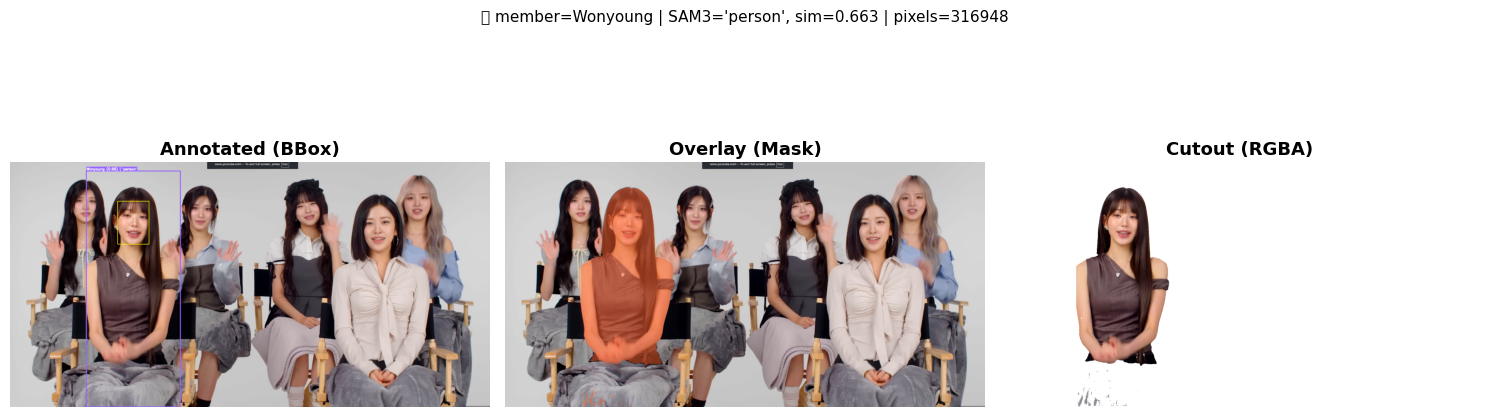



🔍 Prompt: 'wonyoung shirt'
   → member=Wonyoung, SAM3 text='shirt'
   → Found Wonyoung (sim=0.663)
   → body_bbox=[394, 46, 880, 1265]
  ⚠️  SAM3: ไม่พบ mask สำหรับ "shirt" — fallback to body bbox


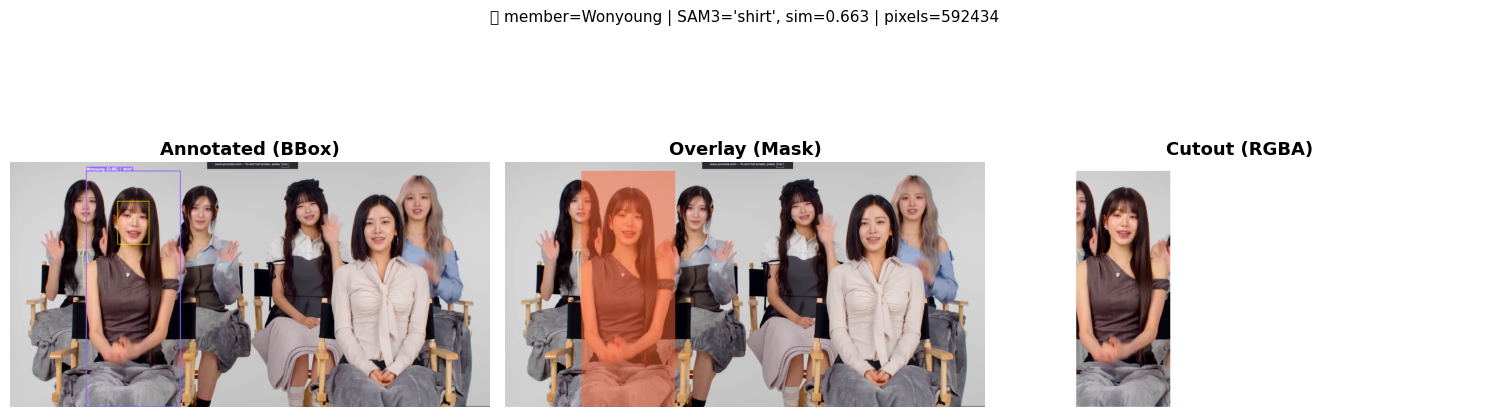



🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.663)
   → body_bbox=[394, 46, 880, 1265]
  ✅ SAM3: "hair" adj_bbox=[394, 46, 880, 1265]
     score=0.957 | proximity=0.606 | overlap=0.996 | combined=0.809
     centroid=(289,387) roi_center=(243,549) pixels=74969


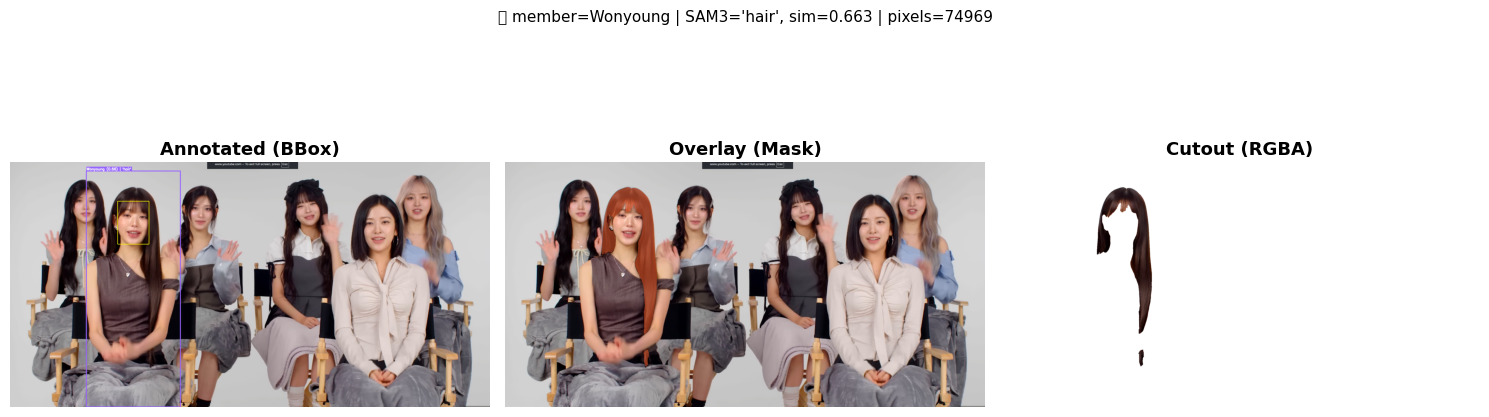

In [35]:
# =============================================================================
# CELL 7.2: ทดสอบ prompts หลายแบบในภาพเดียวกัน
# =============================================================================

TEST_PROMPTS = [
    "wonyoung",
    "wonyoung shirt",
    "wonyoung hair",
]

if test_img is not None:
    for p in TEST_PROMPTS:
        print(f"\n{'='*60}")
        result = segment_from_prompt(test_img, p)
        show_results(result, figsize=(15, 5))

In [36]:
# =============================================================================
# CELL 7.3: บันทึก output
# =============================================================================
import os

os.makedirs("outputs", exist_ok=True)

if test_img is not None and result.get("mask") is not None:
    safe_prompt = TEST_PROMPT.replace(" ", "_")

    # Overlay
    overlay_bgr = cv2.cvtColor(result["overlay"], cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"outputs/{safe_prompt}_overlay.jpg", overlay_bgr)

    # Cutout (RGBA PNG)
    if result.get("cutout") is not None:
        cutout_pil = Image.fromarray(result["cutout"], mode="RGBA")
        cutout_pil.save(f"outputs/{safe_prompt}_cutout.png")

    # Annotated
    annotated_bgr = cv2.cvtColor(result["annotated"], cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"outputs/{safe_prompt}_annotated.jpg", annotated_bgr)

    print(f"✅ บันทึกไฟล์ใน outputs/{safe_prompt}_*.jpg/png")

✅ บันทึกไฟล์ใน outputs/wonyoung_*.jpg/png


In [37]:
# =============================================================================
# Section 8 — Video Processing with Text Prompt 🎬
# =============================================================================
from tqdm.notebook import tqdm
import time


def process_video_with_prompt(
    input_path: str,
    output_path: str,
    prompt: str,
    frame_sampling: int = 3,
    similarity_threshold: float = 0.42,
    confidence_threshold: float = 0.35,
    width_scale: float = 3.0,
    height_top_scale: float = 1.2,
    height_bottom_scale: float = 5.0,
):
    """
    ประมวลผลวิดีโอ frame-by-frame ด้วย InsightFace + SAM 3 text prompt

    Strategy:
      - ประมวลผลทุก frame_sampling frames ด้วย segment_from_prompt()
      - frames ระหว่างกัน: ใช้ mask ล่าสุด (cache) เพื่อความเร็ว
      - output: overlay video (mask ทับด้วยสีพร้อม bbox)

    Args:
        input_path:  path วิดีโอ input
        output_path: path วิดีโอ output
        prompt:      เช่น "wonyoung", "wonyoung shirt"
        frame_sampling: ประมวลผลทุก N frames
    """
    # Parse prompt ครั้งเดียว
    member_name, sam3_text = parse_prompt(prompt)
    overlay_color = MEMBER_COLORS.get(member_name, (255, 100, 50)) if member_name else (255, 100, 50)

    print(f"🎬 Video Processing")
    print(f"   Input : {input_path}")
    print(f"   Output: {output_path}")
    print(f"   Prompt: '{prompt}' → member={member_name}, SAM3='{sam3_text}'")
    print(f"   Frame sampling: every {frame_sampling} frames")

    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"❌ ไม่สามารถเปิดวิดีโอ: {input_path}")
        return

    fps       = cap.get(cv2.CAP_PROP_FPS)
    frame_w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"   Resolution: {frame_w}x{frame_h} @ {fps:.1f}fps, {total_frames} frames")

    os.makedirs(os.path.dirname(output_path) if os.path.dirname(output_path) else ".", exist_ok=True)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(output_path, fourcc, fps, (frame_w, frame_h))

    cached_mask   = None  # mask ล่าสุดที่คำนวณได้
    cached_bbox   = None  # body bbox ล่าสุด
    frames_processed = 0
    frames_hit_cache = 0
    detect_count  = 0
    t_start = time.time()

    pbar = tqdm(total=total_frames, desc=f"Processing [{prompt}]")

    frame_idx = 0
    while True:
        ret, frame_bgr = cap.read()
        if not ret:
            break

        # ===== ประมวลผลเต็ม (ทุก frame_sampling frames) =====
        if frame_idx % frame_sampling == 0:
            result = segment_from_prompt(
                image_bgr=frame_bgr,
                prompt=prompt,
                similarity_threshold=similarity_threshold,
                confidence_threshold=confidence_threshold,
                width_scale=width_scale,
                height_top_scale=height_top_scale,
                height_bottom_scale=height_bottom_scale,
            )
            if result["mask"] is not None and result["mask"].sum() > 100:
                cached_mask = result["mask"]
                cached_bbox = result["body_bbox"]
                detect_count += 1
            else:
                # ไม่ detect ได้ → ล้าง cache
                cached_mask = None
                cached_bbox = None
            frames_processed += 1

        # ===== Render frame =====
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        if cached_mask is not None:
            # Overlay mask
            out_rgb = create_overlay(frame_rgb, cached_mask,
                                     color=overlay_color, alpha=0.5)
            # วาด body bbox
            if cached_bbox is not None:
                bx1, by1, bx2, by2 = cached_bbox
                color_bgr = tuple(int(c) for c in overlay_color[::-1])
                cv2.rectangle(out_rgb, (bx1, by1), (bx2, by2), color_bgr, 3)
            # Label overlay (top-left)
            label = f'{member_name or prompt} | SAM3: "{sam3_text}"'
            cv2.putText(out_rgb, label, (15, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255, 255, 255), 3)
            cv2.putText(out_rgb, label, (15, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.1, tuple(int(c) for c in overlay_color), 2)
        else:
            out_rgb = frame_rgb.copy()
            frames_hit_cache += 1

        out_bgr = cv2.cvtColor(out_rgb, cv2.COLOR_RGB2BGR)
        writer.write(out_bgr)
        frame_idx += 1
        pbar.update(1)

    pbar.close()
    cap.release()
    writer.release()

    elapsed = time.time() - t_start
    print(f"✅ Done\!")
    print(f"   Frames total    : {frame_idx}")
    print(f"   Frames processed: {frames_processed} (SAM3 called)")
    print(f"   Detections      : {detect_count}/{frames_processed}")
    print(f"   Time            : {elapsed:.1f}s ({frame_idx/elapsed:.1f} fps)")
    print(f"   Output saved    : {output_path}")


# ==========================================================================
# TEST 1: prompt = "wonyoung"  → SAM3 text = "person"
# ==========================================================================
process_video_with_prompt(
    input_path  = "Input/IVE-30s.mp4",
    output_path = "outputs/test_wonyoung.mp4",
    prompt      = "wonyoung",
    frame_sampling      = 3,
    similarity_threshold = 0.42,
    confidence_threshold = 0.35,
)

🎬 Video Processing
   Input : Input/IVE-30s.mp4
   Output: outputs/test_wonyoung.mp4
   Prompt: 'wonyoung' → member=Wonyoung, SAM3='person'
   Frame sampling: every 3 frames
   Resolution: 1920x1080 @ 30.0fps, 909 frames


Processing [wonyoung]:   0%|          | 0/909 [00:00<?, ?it/s]


🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.397)
   → body_bbox=[772, 0, 1243, 1079]
  ✅ SAM3: "person" adj_bbox=[772, 0, 1243, 1079]
     score=0.898 | proximity=0.629 | overlap=0.647 | combined=0.714
     centroid=(192,609) roi_center=(236,486) pixels=332408

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.389)
   → body_bbox=[776, 0, 1235, 1079]
  ✅ SAM3: "person" adj_bbox=[776, 0, 1235, 1079]
     score=0.922 | proximity=0.634 | overlap=0.641 | combined=0.722
     centroid=(189,608) roi_center=(230,486) pixels=329602

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.458)
   → body_bbox=[776, 0, 1229, 1079]
  ✅ SAM3: "person" adj_bbox=[776, 0, 1229, 1079]
     score=0.930 

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


   → Found Wonyoung (sim=0.663)
   → body_bbox=[394, 46, 880, 1265]

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
  ⚠️  SAM3: ไม่พบ mask สำหรับ "shirt" — fallback to body bbox
   → Found Wonyoung (sim=0.490)
   → body_bbox=[283, 108, 637, 1079]
  ✅ SAM3: "person" adj_bbox=[283, 108, 637, 1079]
     score=0.836 | proximity=0.898 | overlap=0.769 | combined=0.847
     centroid=(182,413) roi_center=(177,437) pixels=151529

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.419)
   → body_bbox=[269, 104, 638, 1079]
  ✅ SAM3: "person" adj_bbox=[269, 104, 638, 1079]
     score=0.898 | proximity=0.834 | overlap=0.726 | combined=0.826
     centroid=(199,470) roi_center=(184,439) pixels=173364

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.461)
   → body_bbox=[265, 102, 628, 1079]
  ✅ SAM3: "person" adj_bbox=[265, 102, 628, 1079]
     score=0.910 | proximity=0.693 | overlap=0.684 | combined=0.756
  

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4



🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.585)
   → body_bbox=[262, 107, 622, 1079]
  ✅ SAM3: "person" adj_bbox=[262, 107, 622, 1079]
     score=0.824 | proximity=0.805 | overlap=0.734 | combined=0.793
     centroid=(200,459) roi_center=(180,437) pixels=168852

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.609)
   → body_bbox=[260, 107, 620, 1079]
  ✅ SAM3: "person" adj_bbox=[260, 107, 620, 1079]
     score=0.867 | proximity=0.770 | overlap=0.721 | combined=0.787
     centroid=(206,456) roi_center=(180,437) pixels=166016

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.594)
   → body_bbox=[262, 109, 619, 1079]
  ✅ SAM3: "person" adj_bbox=[262, 109, 619, 1079]
     score=0.844 | proximity=0.739 | overlap=0.697 | combined=0.760
     centroid=(205,484) roi_center=(178,436) pixels=179215

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  ✅ SAM3: "shirt" adj_bbox=[1828, 0, 2389, 1265]
     score=0.875 | proximity=0.570 | overlap=0.670 | combined=0.686
  ✅ SAM3: "person" adj_bbox=[305, 116, 653, 1077]
     score=0.914 | proximity=0.654 | overlap=0.655 | combined=0.732
     centroid=(183,557) roi_center=(174,432) pixels=237583
     centroid=(386,572) roi_center=(280,569) pixels=38142

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.697)
   → body_bbox=[305, 121, 653, 1070]
  ✅ SAM3: "person" adj_bbox=[305, 121, 653, 1070]
     score=0.898 | proximity=0.721 | overlap=0.689 | combined=0.766
     centroid=(193,502) roi_center=(174,427) pixels=196912

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.671)
   → body_bbox=[305, 125, 653, 1061]
  ✅ SAM3: "person" adj_bbox=[305, 125, 653, 1061]
     score=0.898 | proximity=0.661 | overlap=0.670 | combined=0.735
     centroid=(188,535) roi_center=(174,421) pixels=226249

🔍 Prompt: 'wonyoung'
   → mem

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4



🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.668)
   → body_bbox=[301, 123, 655, 1078]
  ✅ SAM3: "person" adj_bbox=[301, 123, 655, 1078]
     score=0.910 | proximity=0.663 | overlap=0.663 | combined=0.737
     centroid=(189,547) roi_center=(177,430) pixels=234968

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.663)
   → body_bbox=[297, 116, 654, 1079]
  ✅ SAM3: "person" adj_bbox=[297, 116, 654, 1079]
     score=0.871 | proximity=0.680 | overlap=0.676 | combined=0.736
     centroid=(196,536) roi_center=(178,433) pixels=218881

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.666)
   → body_bbox=[296, 116, 653, 1079]
  ✅ SAM3: "person" adj_bbox=[296, 116, 653, 1079]
     score=0.879 | proximity=0.675 | overlap=0.669 | combined=0.735
     centroid=(194,542) roi_center=(178,433) pixels=222268

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


   → Found Wonyoung (sim=0.384)
   → body_bbox=[364, 122, 649, 1079]
  ✅ SAM3: "shirt" adj_bbox=[1284, 0, 1799, 1199]
     score=0.707 | proximity=0.715 | overlap=0.661 | combined=0.699
     centroid=(224,448) roi_center=(258,540) pixels=31183
  ✅ SAM3: "person" adj_bbox=[364, 122, 649, 1079]
     score=0.848 | proximity=0.696 | overlap=0.640 | combined=0.727
     centroid=(171,476) roi_center=(142,431) pixels=161884

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.399)
   → body_bbox=[363, 124, 645, 1079]
  ✅ SAM3: "person" adj_bbox=[363, 124, 645, 1079]
     score=0.863 | proximity=0.707 | overlap=0.651 | combined=0.740
     centroid=(170,451) roi_center=(141,430) pixels=152951

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'


/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


   → Found Wonyoung (sim=0.377)
   → body_bbox=[361, 122, 643, 1071]
  ✅ SAM3: "person" adj_bbox=[361, 122, 643, 1071]
     score=0.902 | proximity=0.682 | overlap=0.626 | combined=0.734
     centroid=(171,476) roi_center=(141,427) pixels=163192

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  ✅ SAM3: "person" adj_bbox=[1284, 0, 1799, 1199]
     score=0.906 | proximity=0.779 | overlap=0.808 | combined=0.824
     centroid=(226,584) roi_center=(258,540) pixels=260370
  ✅ SAM3: "person" adj_bbox=[677, 0, 1421, 1079]
     score=0.953 | proximity=0.609 | overlap=0.705 | combined=0.736
     centroid=(352,656) roi_center=(372,486) pixels=495094

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.580)
   → body_bbox=[678, 0, 1428, 1079]
  ✅ SAM3: "person" adj_bbox=[678, 0, 1428, 1079]
     score=0.949 | proximity=0.610 | overlap=0.707 | combined=0.736
     centroid=(352,655) roi_center=(375,486) pixels=496455

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.565)
   → body_bbox=[679, 0, 1429, 1079]
  ✅ SAM3: "person" adj_bbox=[679, 0, 1429, 1079]
     score=0.953 | proximity=0.610 | overlap=0.707 | combined=0.737
     centroid=(351,655) roi_center=(375,486) pixels=496052

🔍 Prompt: 'wonyoung'
   → member

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4



🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.651)
   → body_bbox=[676, 0, 1423, 1079]
  ✅ SAM3: "person" adj_bbox=[676, 0, 1423, 1079]
     score=0.949 | proximity=0.612 | overlap=0.709 | combined=0.738
     centroid=(354,654) roi_center=(374,486) pixels=496952

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.695)
   → body_bbox=[681, 0, 1416, 1079]
  ✅ SAM3: "person" adj_bbox=[681, 0, 1416, 1079]
     score=0.941 | proximity=0.613 | overlap=0.703 | combined=0.734
     centroid=(349,653) roi_center=(368,486) pixels=496771

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyoung (sim=0.655)
   → body_bbox=[678, 0, 1413, 1079]
  ✅ SAM3: "person" adj_bbox=[678, 0, 1413, 1079]
     score=0.941 | proximity=0.615 | overlap=0.705 | combined=0.735
     centroid=(352,653) roi_center=(368,486) pixels=497334

🔍 Prompt: 'wonyoung'
   → member=Wonyoung, SAM3 text='person'
   → Found Wonyo

In [38]:
# =============================================================================
# TEST 2: prompt = "wonyoung hair"  → SAM3 text = "hair"
# =============================================================================
process_video_with_prompt(
    input_path  = "Input/IVE-30s.mp4",
    output_path = "outputs/test_wonyoung_hair.mp4",
    prompt      = "wonyoung hair",
    frame_sampling      = 3,
    similarity_threshold = 0.42,
    confidence_threshold = 0.35,
)

🎬 Video Processing
   Input : Input/IVE-30s.mp4
   Output: outputs/test_wonyoung_hair.mp4
   Prompt: 'wonyoung hair' → member=Wonyoung, SAM3='hair'
   Frame sampling: every 3 frames
   Resolution: 1920x1080 @ 30.0fps, 909 frames


Processing [wonyoung hair]:   0%|          | 0/909 [00:00<?, ?it/s]


🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.397)
   → body_bbox=[772, 0, 1243, 1079]
  ✅ SAM3: "hair" adj_bbox=[772, 0, 1243, 1079]
     score=0.973 | proximity=0.872 | overlap=0.660 | combined=0.849
     centroid=(219,474) roi_center=(236,486) pixels=120467

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.389)
   → body_bbox=[776, 0, 1235, 1079]
  ✅ SAM3: "hair" adj_bbox=[776, 0, 1235, 1079]
     score=0.977 | proximity=0.840 | overlap=0.661 | combined=0.836
     centroid=(210,463) roi_center=(230,486) pixels=116247

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.458)
   → body_bbox=[776, 0, 1229, 1079]
  ✅ SAM3: "hair" adj_bbox=[776, 0, 1229, 1079]
     

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


   → Found Wonyoung (sim=0.564)
   → body_bbox=[278, 107, 635, 1075]
  ✅ SAM3: "shirt" adj_bbox=[1284, 0, 1799, 1199]
     score=0.707 | proximity=0.715 | overlap=0.661 | combined=0.699
     centroid=(224,448) roi_center=(258,540) pixels=31183
  ✅ SAM3: "hair" adj_bbox=[278, 107, 635, 1075]
     score=0.949 | proximity=0.653 | overlap=0.701 | combined=0.754
     centroid=(205,329) roi_center=(178,436) pixels=47785

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.500)
   → body_bbox=[279, 112, 636, 1055]
  ✅ SAM3: "hair" adj_bbox=[279, 112, 636, 1055]
     score=0.949 | proximity=0.658 | overlap=0.697 | combined=0.755
     centroid=(205,324) roi_center=(178,424) pixels=47686

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.541)
   → body_bbox=[278, 107, 638, 1068]
  ✅ SAM3: "hair" adj_bbox=[278, 107, 638, 1068]
     score=0.949 | proximity=0.654 | overlap=0.709 | combined=0.756
     centroid=(207,328

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4



🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.564)
   → body_bbox=[285, 105, 642, 1079]
  ✅ SAM3: "hair" adj_bbox=[285, 105, 642, 1079]
     score=0.945 | proximity=0.655 | overlap=0.712 | combined=0.756
     centroid=(202,328) roi_center=(178,438) pixels=48297

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.571)
   → body_bbox=[287, 105, 641, 1079]
  ✅ SAM3: "hair" adj_bbox=[287, 105, 641, 1079]
     score=0.945 | proximity=0.654 | overlap=0.707 | combined=0.755
     centroid=(200,327) roi_center=(177,438) pixels=48045

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.565)
   → body_bbox=[285, 100, 642, 1079]
  ✅ SAM3: "hair" adj_bbox=[285, 100, 642, 1079]
     score=0.945 | proximity=0.657 | overlap=0.713 | combined=0.757
     centroid=(202,331) roi_center=(178,441) pixels=47895

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Fo

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


   → Found Wonyoung (sim=0.663)
   → body_bbox=[394, 46, 880, 1265]

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
  ⚠️  SAM3: ไม่พบ mask สำหรับ "shirt" — fallback to body bbox
   → Found Wonyoung (sim=0.509)
   → body_bbox=[354, 116, 645, 1079]
  ✅ SAM3: "hair" adj_bbox=[354, 116, 645, 1079]
     score=0.965 | proximity=0.461 | overlap=0.648 | combined=0.659
     centroid=(212,257) roi_center=(146,433) pixels=48689

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.447)
   → body_bbox=[359, 119, 647, 1079]
  ✅ SAM3: "hair" adj_bbox=[359, 119, 647, 1079]
     score=0.961 | proximity=0.457 | overlap=0.643 | combined=0.655
     centroid=(211,253) roi_center=(144,432) pixels=47928

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'


/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


   → Found Wonyoung (sim=0.387)
   → body_bbox=[351, 112, 663, 1079]
  ✅ SAM3: "hair" adj_bbox=[351, 112, 663, 1079]
     score=0.953 | proximity=0.481 | overlap=0.738 | combined=0.687
     centroid=(220,268) roi_center=(156,435) pixels=49048

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.382)
   → body_bbox=[356, 113, 665, 1079]
  ✅ SAM3: "hair" adj_bbox=[356, 113, 665, 1079]
     score=0.953 | proximity=0.487 | overlap=0.764 | combined=0.696
     centroid=(216,267) roi_center=(154,435) pixels=48364

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.419)
   → body_bbox=[359, 114, 665, 1079]
  ✅ SAM3: "hair" adj_bbox=[359, 114, 665, 1079]
     score=0.898 | proximity=0.489 | overlap=0.769 | combined=0.682
     centroid=(212,265) roi_center=(153,434) pixels=48233

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.439)
   → body_bbox=[366, 112, 657, 1079]
  ✅ 

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  ⚠️  SAM3: ไม่พบ mask สำหรับ "pants" — fallback to body bbox
  ✅ SAM3: "hair" adj_bbox=[675, 0, 1410, 1079]
     score=0.953 | proximity=0.820 | overlap=0.872 | combined=0.873
     centroid=(401,519) roi_center=(368,486) pixels=182471

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.686)
   → body_bbox=[674, 0, 1406, 1079]
  ✅ SAM3: "hair" adj_bbox=[674, 0, 1406, 1079]
     score=0.953 | proximity=0.813 | overlap=0.869 | combined=0.869
     centroid=(401,520) roi_center=(366,486) pixels=182671

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.664)
   → body_bbox=[673, 0, 1405, 1079]
  ✅ SAM3: "hair" adj_bbox=[673, 0, 1405, 1079]
     score=0.953 | proximity=0.813 | overlap=0.868 | combined=0.869
     centroid=(401,520) roi_center=(366,486) pixels=182318

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.648)
   → body_bbox=[671, 0, 1406, 1079]
  ✅ SAM3: "hai

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4



🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.679)
   → body_bbox=[672, 0, 1407, 1079]
  ✅ SAM3: "hair" adj_bbox=[672, 0, 1407, 1079]
     score=0.949 | proximity=0.817 | overlap=0.870 | combined=0.870
     centroid=(401,521) roi_center=(368,486) pixels=181691

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.656)
   → body_bbox=[680, 0, 1406, 1079]
  ✅ SAM3: "hair" adj_bbox=[680, 0, 1406, 1079]
     score=0.953 | proximity=0.820 | overlap=0.862 | combined=0.871
     centroid=(394,522) roi_center=(363,486) pixels=181383

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.607)
   → body_bbox=[336, 111, 693, 1079]
  ✅ SAM3: "hair" adj_bbox=[336, 111, 693, 1079]
     score=0.957 | proximity=0.645 | overlap=0.948 | combined=0.815
     centroid=(211,336) roi_center=(178,436) pixels=51097

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Foun

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  ✅ SAM3: "hair" adj_bbox=[346, 107, 700, 1050]
     score=0.945 | proximity=0.657 | overlap=0.995 | combined=0.828
     centroid=(210,339) roi_center=(177,424) pixels=48270
  ✅ SAM3: "face" adj_bbox=[321, 0, 952, 1265]
     score=0.875 | proximity=0.574 | overlap=1.000 | combined=0.771
     centroid=(313,335) roi_center=(316,569) pixels=24190

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.666)
   → body_bbox=[351, 104, 699, 1072]
  ✅ SAM3: "hair" adj_bbox=[351, 104, 699, 1072]
     score=0.945 | proximity=0.648 | overlap=0.995 | combined=0.824
     centroid=(202,329) roi_center=(174,436) pixels=40962

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.615)
   → body_bbox=[353, 106, 701, 1079]
  ✅ SAM3: "hair" adj_bbox=[353, 106, 701, 1079]
     score=0.949 | proximity=0.629 | overlap=0.996 | combined=0.817
     centroid=(200,315) roi_center=(174,438) pixels=40086

🔍 Prompt: 'wonyoung hair'
   → memb

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  ✅ SAM3: "hair" adj_bbox=[353, 115, 701, 1039]
     score=0.949 | proximity=0.611 | overlap=1.000 | combined=0.810
     centroid=(198,283) roi_center=(174,416) pixels=37186

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.617)
   → body_bbox=[352, 119, 703, 1049]
  ✅ SAM3: "hair" adj_bbox=[352, 119, 703, 1049]
     score=0.957 | proximity=0.591 | overlap=1.000 | combined=0.803
     centroid=(199,270) roi_center=(176,418) pixels=37585

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.658)
   → body_bbox=[352, 117, 700, 1078]
  ✅ SAM3: "hair" adj_bbox=[352, 117, 700, 1078]
     score=0.949 | proximity=0.583 | overlap=1.000 | combined=0.797
     centroid=(198,274) roi_center=(174,432) pixels=38932

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.657)
   → body_bbox=[354, 125, 696, 1055]
  ✅ SAM3: "hair" adj_bbox=[354, 125, 696, 1055]
     score=0.953 | proxim

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


   → Found Wonyoung (sim=0.513)
   → body_bbox=[359, 112, 647, 1079]
  ✅ SAM3: "arm" adj_bbox=[321, 0, 952, 1265]
     score=0.652 | proximity=0.485 | overlap=0.822 | combined=0.619
     centroid=(439,796) roi_center=(316,569) pixels=39862
  ✅ SAM3: "hair" adj_bbox=[359, 112, 647, 1079]
     score=0.969 | proximity=0.484 | overlap=0.741 | combined=0.693
     centroid=(201,261) roi_center=(144,435) pixels=48833

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.541)
   → body_bbox=[362, 116, 647, 1079]
  ✅ SAM3: "hair" adj_bbox=[362, 116, 647, 1079]
     score=0.973 | proximity=0.482 | overlap=0.738 | combined=0.693
     centroid=(199,259) roi_center=(142,433) pixels=49508

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.522)
   → body_bbox=[366, 116, 645, 1079]
  ✅ SAM3: "hair" adj_bbox=[366, 116, 645, 1079]
     score=0.977 | proximity=0.479 | overlap=0.719 | combined=0.688
     centroid=(197,261) ro

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4



🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.382)
   → body_bbox=[367, 120, 646, 1079]
  ✅ SAM3: "hair" adj_bbox=[367, 120, 646, 1079]
     score=0.977 | proximity=0.478 | overlap=0.716 | combined=0.687
     centroid=(197,259) roi_center=(140,432) pixels=50769

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'

🔍 Prompt: 'wonyoung hair'
   →

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  ✅ SAM3: "hair" adj_bbox=[353, 115, 698, 1079]
     score=0.969 | proximity=0.638 | overlap=1.000 | combined=0.828
     centroid=(204,328) roi_center=(172,434) pixels=45084
   → Found Wonyoung (sim=0.663)
   → body_bbox=[394, 46, 880, 1265]

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
  ✅ SAM3: "neck" adj_bbox=[321, 0, 952, 1265]
     score=0.742 | proximity=0.754 | overlap=1.000 | combined=0.812
     centroid=(302,470) roi_center=(316,569) pixels=10330
   → Found Wonyoung (sim=0.654)
   → body_bbox=[351, 115, 699, 1079]
  ✅ SAM3: "hair" adj_bbox=[351, 115, 699, 1079]
     score=0.965 | proximity=0.639 | overlap=1.000 | combined=0.827
     centroid=(204,325) roi_center=(174,434) pixels=44964

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.662)
   → body_bbox=[350, 117, 698, 1078]
  ✅ SAM3: "hair" adj_bbox=[350, 117, 698, 1078]
     score=0.961 | proximity=0.638 | overlap=1.000 | combined=0.826
     centroid=(203,322) ro

/root/SEGMENTATION_IVE/.venv/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4



🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.635)
   → body_bbox=[343, 120, 694, 1038]
  ✅ SAM3: "hair" adj_bbox=[343, 120, 694, 1038]
     score=0.941 | proximity=0.611 | overlap=1.000 | combined=0.807
     centroid=(200,281) roi_center=(176,413) pixels=40318

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.634)
   → body_bbox=[343, 117, 694, 1053]
  ✅ SAM3: "hair" adj_bbox=[343, 117, 694, 1053]
     score=0.934 | proximity=0.619 | overlap=1.000 | combined=0.809
     centroid=(202,296) roi_center=(176,421) pixels=42244

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Found Wonyoung (sim=0.641)
   → body_bbox=[340, 111, 694, 1072]
  ✅ SAM3: "hair" adj_bbox=[340, 111, 694, 1072]
     score=0.934 | proximity=0.620 | overlap=1.000 | combined=0.809
     centroid=(205,306) roi_center=(177,432) pixels=43129

🔍 Prompt: 'wonyoung hair'
   → member=Wonyoung, SAM3 text='hair'
   → Fo

🎭 Segment All IVE Members in Input/Input.png
✅ Loaded: 2481×1266 px
🔍 InsightFace: detecting all members...
   พบ 6 คน: ['Leeseo', 'Yujin', 'Wonyoung', 'Gaeul', 'Liz', 'Rei']

✂️  Segmenting Liz (sim=0.642)...
  ✅ SAM3: "person" adj_bbox=[1828, 0, 2389, 1265]
     score=0.754 | proximity=0.597 | overlap=0.899 | combined=0.719
     centroid=(336,396) roi_center=(280,569) pixels=129873

✂️  Segmenting Gaeul (sim=0.650)...
  ✅ SAM3: "person" adj_bbox=[152, 0, 624, 1216]
     score=0.805 | proximity=0.631 | overlap=0.863 | combined=0.741
     centroid=(192,410) roi_center=(236,547) pixels=131510

✂️  Segmenting Rei (sim=0.555)...
  ✅ SAM3: "person" adj_bbox=[1284, 0, 1799, 1199]
     score=0.906 | proximity=0.779 | overlap=0.808 | combined=0.824
     centroid=(226,584) roi_center=(258,540) pixels=260370

✂️  Segmenting Leeseo (sim=0.665)...
  ✅ SAM3: "person" adj_bbox=[744, 0, 1232, 1265]
     score=0.895 | proximity=0.840 | overlap=0.853 | combined=0.859
     centroid=(265,596) roi_center

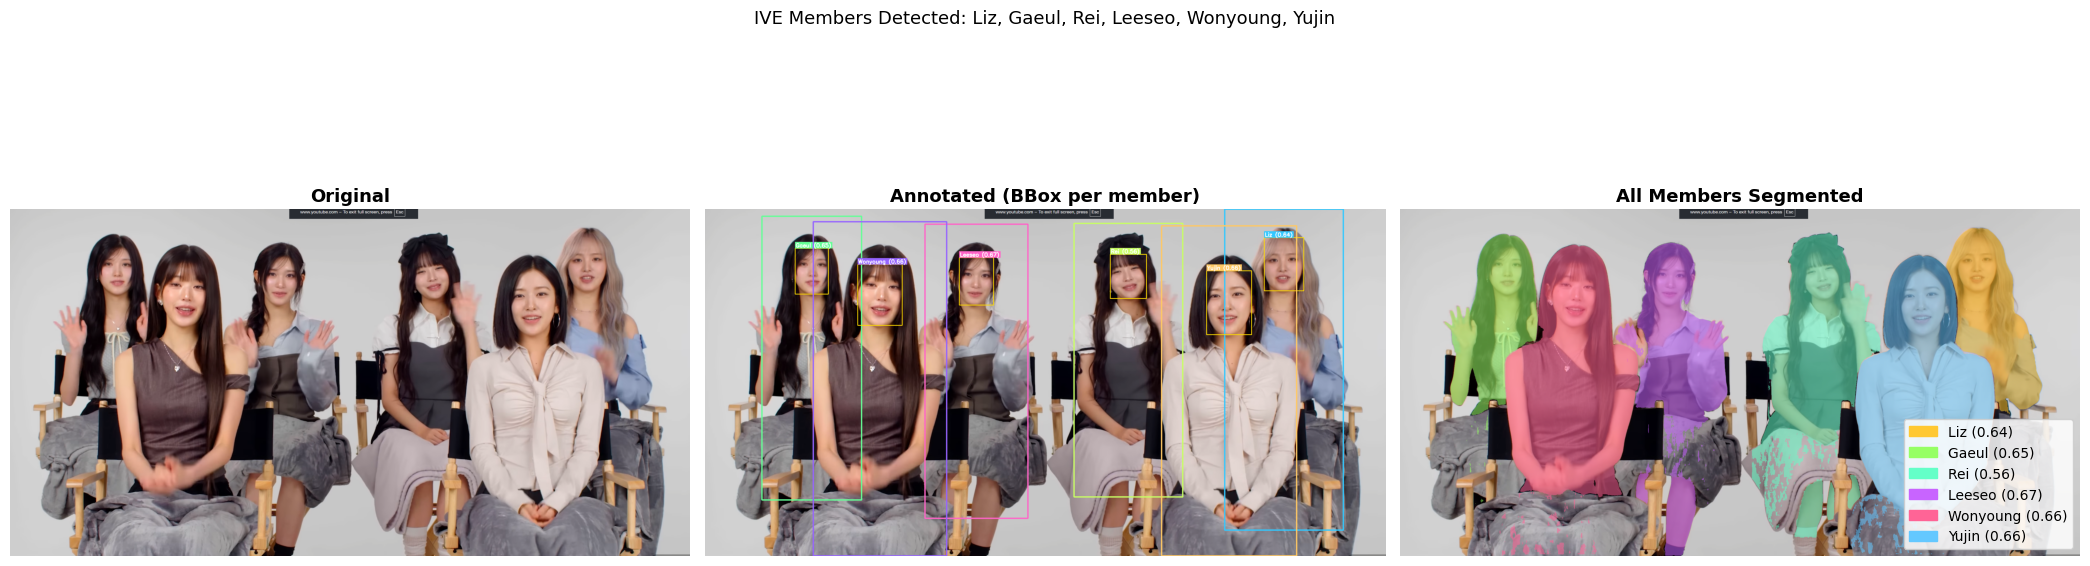


💾 บันทึก: outputs/all_members_segmented.jpg

✅ สรุป: segment 6 คน — ['Liz', 'Gaeul', 'Rei', 'Leeseo', 'Wonyoung', 'Yujin']


In [39]:
# =============================================================================
# CELL: Segment ทุกสมาชิก IVE ในภาพเดียว — Input/Input.png
# =============================================================================

def segment_all_members_in_image(
    image_bgr: np.ndarray,
    similarity_threshold: float = 0.42,
    confidence_threshold: float = 0.35,
    show_plot: bool = True,
    save_path: str = None,
):
    """
    Detect + Segment สมาชิก IVE ทุกคนที่พบในภาพ

    Flow:
      InsightFace → detect all faces → identify each member
      → body_bbox per member → SAM3 "person" per member
      → รวม masks ด้วย color ประจำสมาชิกแต่ละคน

    Returns:
        dict: {member_name: {mask, body_bbox, face_bbox, similarity}}
    """
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    img_h, img_w = image_bgr.shape[:2]

    # ── 1. Detect ทุกคนในภาพ ────────────────────────────────────────────────
    print("🔍 InsightFace: detecting all members...")
    detections = detect_and_identify_members(image_bgr, threshold=similarity_threshold)

    # กรองเฉพาะคนที่ระบุตัวตนได้ (ไม่ใช่ Unknown) และไม่ซ้ำ
    seen = set()
    valid_dets = []
    for det in sorted(detections, key=lambda d: d["similarity"], reverse=True):
        name = det["name"]
        if name != "Unknown" and name not in seen:
            seen.add(name)
            valid_dets.append(det)

    if not valid_dets:
        print("❌ ไม่พบสมาชิก IVE ในภาพ")
        return {}

    print(f"   พบ {len(valid_dets)} คน: {[d['name'] for d in valid_dets]}")

    # Sort: คนข้างหลัง (face centroid Y ต่ำ = อยู่สูงในภาพ) segment ก่อน
    # คนข้างหน้า (centroid Y สูง = อยู่ต่ำในภาพ) segment ทีหลัง
    # → mask คนข้างหน้าจะวาดทับคนข้างหลังอัตโนมัติ
    valid_dets.sort(key=lambda d: (d["face_bbox"][1] + d["face_bbox"][3]) / 2)

    # ── 2. Segment แต่ละคน ──────────────────────────────────────────────────
    results = {}
    for det in valid_dets:
        name      = det["name"]
        face_bbox = det["face_bbox"]
        body_bbox = det["body_bbox"]
        sim       = det["similarity"]

        print(f"\n✂️  Segmenting {name} (sim={sim:.3f})...")

        mask = segment_roi_with_text(
            image_rgb, body_bbox, "person",
            confidence_threshold=confidence_threshold,
            bbox_expand=1.3,
        )

        results[name] = {
            "mask":      mask,
            "face_bbox": face_bbox,
            "body_bbox": body_bbox,
            "similarity": sim,
        }

    # ── 3. รวม masks และสร้าง visualization ──────────────────────────────────
    # Combined overlay — ทับ mask ทุกคนด้วยสีประจำตัว
    combined_overlay = image_rgb.copy().astype(np.float32)
    annotated        = image_rgb.copy()

    for name, info in results.items():
        mask      = info["mask"]
        color_rgb = MEMBER_COLORS.get(name, MEMBER_COLORS["Unknown"])
        color_arr = np.array(color_rgb, dtype=np.float32)
        color_bgr = tuple(int(c) for c in color_rgb[::-1])

        # Overlay
        combined_overlay[mask > 0] = (
            combined_overlay[mask > 0] * 0.45 + color_arr * 0.55
        )

        # Annotated: body bbox + face bbox + label
        bx1, by1, bx2, by2 = info["body_bbox"]
        fx1, fy1, fx2, fy2 = info["face_bbox"]
        cv2.rectangle(annotated, (bx1, by1), (bx2, by2), color_bgr, 3)
        cv2.rectangle(annotated, (fx1, fy1), (fx2, fy2), (255, 220, 0), 2)

        label = f"{name} ({info['similarity']:.2f})"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.65, 2)
        cv2.rectangle(annotated,
                      (fx1, max(0, fy1 - th - 8)),
                      (fx1 + tw + 4, fy1), color_bgr, -1)
        cv2.putText(annotated, label,
                    (fx1 + 2, max(th, fy1 - 4)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)

    combined_overlay = np.clip(combined_overlay, 0, 255).astype(np.uint8)

    # ── 4. Plot ──────────────────────────────────────────────────────────────
    if show_plot:
        fig, axes = plt.subplots(1, 3, figsize=(21, 7))

        axes[0].imshow(image_rgb)
        axes[0].set_title("Original", fontsize=13, fontweight="bold")
        axes[0].axis("off")

        axes[1].imshow(annotated)
        axes[1].set_title("Annotated (BBox per member)", fontsize=13, fontweight="bold")
        axes[1].axis("off")

        axes[2].imshow(combined_overlay)
        axes[2].set_title("All Members Segmented", fontsize=13, fontweight="bold")
        axes[2].axis("off")

        # Legend
        legend_handles = []
        import matplotlib.patches as mpatches
        for name in results:
            c = np.array(MEMBER_COLORS.get(name, (200, 200, 200))) / 255.0
            legend_handles.append(mpatches.Patch(color=c, label=f"{name} ({results[name]['similarity']:.2f})"))
        axes[2].legend(handles=legend_handles, loc="lower right",
                       fontsize=10, framealpha=0.85)

        found_names = ", ".join(results.keys())
        plt.suptitle(f"IVE Members Detected: {found_names}", fontsize=13, y=1.01)
        plt.tight_layout()
        plt.show()

    # ── 5. Save ──────────────────────────────────────────────────────────────
    if save_path:
        os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else ".", exist_ok=True)
        overlay_bgr = cv2.cvtColor(combined_overlay, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, overlay_bgr)
        print(f"\n💾 บันทึก: {save_path}")

    print(f"\n✅ สรุป: segment {len(results)} คน — {list(results.keys())}")
    return results


# ── รัน: segment ทุกสมาชิกใน Input/Input.png ────────────────────────────────
print("=" * 60)
print("🎭 Segment All IVE Members in Input/Input.png")
print("=" * 60)

img_all = cv2.imread("Input/Input.png")
if img_all is None:
    print("❌ ไม่พบ Input/Input.png")
else:
    print(f"✅ Loaded: {img_all.shape[1]}×{img_all.shape[0]} px")
    all_results = segment_all_members_in_image(
        image_bgr            = img_all,
        similarity_threshold = 0.42,
        confidence_threshold = 0.35,
        show_plot            = True,
        save_path            = "outputs/all_members_segmented.jpg",
    )


In [40]:
# =============================================================================
# CELL: Segment ทุกสมาชิก IVE ใน Video — Input/IVE-30s.mp4
# =============================================================================

def process_video_all_members(
    input_path: str,
    output_path: str,
    frame_sampling: int = 3,
    similarity_threshold: float = 0.42,
    confidence_threshold: float = 0.35,
):
    """
    ประมวลผลวิดีโอโดย segment ทุกสมาชิก IVE ที่พบในแต่ละ frame

    Flow (ทุก frame_sampling frames):
      InsightFace → detect all faces → identify each member
      → body_bbox per member → SAM3 "person" per member
      → รวม masks ทุกคนด้วยสีประจำตัว → render overlay frame

    Frames ระหว่างกัน: ใช้ cached masks จาก frame ล่าสุด

    Args:
        input_path:  path วิดีโอ input
        output_path: path วิดีโอ output
        frame_sampling: ประมวลผลเต็มทุก N frames
    """
    print("🎬 Video: Segment All IVE Members")
    print(f"   Input : {input_path}")
    print(f"   Output: {output_path}")
    print(f"   Frame sampling: every {frame_sampling} frames")

    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"❌ ไม่สามารถเปิดวิดีโอ: {input_path}")
        return

    fps          = cap.get(cv2.CAP_PROP_FPS)
    frame_w      = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h      = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"   Resolution: {frame_w}×{frame_h} @ {fps:.1f}fps, {total_frames} frames")

    os.makedirs(
        os.path.dirname(output_path) if os.path.dirname(output_path) else ".",
        exist_ok=True
    )
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(output_path, fourcc, fps, (frame_w, frame_h))

    # Cache: {member_name: {"mask": np.ndarray, "body_bbox": np.ndarray}}
    cached: dict = {}

    # Stats
    frames_processed = 0
    detect_counts    = {}  # {name: int}
    t_start          = time.time()

    pbar = tqdm(total=total_frames, desc="Segment All Members")

    frame_idx = 0
    while True:
        ret, frame_bgr = cap.read()
        if not ret:
            break

        # ── ประมวลผลเต็ม (ทุก frame_sampling frames) ────────────────────────
        if frame_idx % frame_sampling == 0:
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

            # Detect ทุกคน
            detections = detect_and_identify_members(
                frame_bgr, threshold=similarity_threshold
            )

            # กรองเฉพาะ known members ไม่ซ้ำ
            seen = set()
            valid_dets = []
            for det in sorted(detections, key=lambda d: d["similarity"], reverse=True):
                if det["name"] != "Unknown" and det["name"] not in seen:
                    seen.add(det["name"])
                    valid_dets.append(det)

            # Sort: background first → foreground last (mask ทับถูกลำดับ)
            valid_dets.sort(key=lambda d: (d["face_bbox"][1] + d["face_bbox"][3]) / 2)

            # Segment แต่ละคน
            new_cache = {}
            for det in valid_dets:
                name      = det["name"]
                body_bbox = det["body_bbox"]
                mask = segment_roi_with_text(
                    frame_rgb, body_bbox, "person",
                    confidence_threshold=confidence_threshold,
                    bbox_expand=1.3,
                )
                if mask.sum() > 80:
                    new_cache[name] = {
                        "mask":      mask,
                        "body_bbox": body_bbox,
                        "face_bbox": det["face_bbox"],
                        "similarity": det["similarity"],
                    }
                    detect_counts[name] = detect_counts.get(name, 0) + 1

            # อัปเดต cache: ถ้าไม่ detect ใคร → ล้าง cache คนนั้น
            cached = new_cache
            frames_processed += 1

        # ── Render frame ────────────────────────────────────────────────────
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        out_rgb   = frame_rgb.copy().astype(np.float32)

        for name, info in cached.items():
            mask      = info["mask"]
            color_rgb = MEMBER_COLORS.get(name, MEMBER_COLORS["Unknown"])
            color_arr = np.array(color_rgb, dtype=np.float32)
            color_bgr = tuple(int(c) for c in color_rgb[::-1])

            # Overlay mask
            out_rgb[mask > 0] = out_rgb[mask > 0] * 0.45 + color_arr * 0.55

            # mask overlay only — ไม่มี bbox/label

        out_bgr = cv2.cvtColor(
            np.clip(out_rgb, 0, 255).astype(np.uint8),
            cv2.COLOR_RGB2BGR
        )
        writer.write(out_bgr)
        frame_idx += 1
        pbar.update(1)

    pbar.close()
    cap.release()
    writer.release()

    elapsed = time.time() - t_start
    print(f"\n✅ Done!")
    print(f"   Total frames    : {frame_idx}")
    print(f"   Frames processed: {frames_processed} (SAM3 called)")
    print(f"   Time            : {elapsed:.1f}s  ({frame_idx/elapsed:.1f} fps output)")
    print(f"   Members detected per processed frame:")
    for name, cnt in sorted(detect_counts.items(), key=lambda x: -x[1]):
        pct = cnt / frames_processed * 100 if frames_processed else 0
        bar = "█" * int(pct / 5)
        print(f"     {name:<12}: {cnt:>4}×  {pct:5.1f}%  {bar}")
    print(f"   Output: {output_path}")


# ── รัน ──────────────────────────────────────────────────────────────────────
process_video_all_members(
    input_path  = "Input/IVE-30s.mp4",
    output_path = "outputs/all_members_video.mp4",
    frame_sampling      = 3,
    similarity_threshold = 0.42,
    confidence_threshold = 0.35,
)


🎬 Video: Segment All IVE Members
   Input : Input/IVE-30s.mp4
   Output: outputs/all_members_video.mp4
   Frame sampling: every 3 frames
   Resolution: 1920×1080 @ 30.0fps, 909 frames


Segment All Members:   0%|          | 0/909 [00:00<?, ?it/s]

  ✅ SAM3: "person" adj_bbox=[446, 0, 988, 1079]
     score=0.844 | proximity=0.614 | overlap=0.814 | combined=0.733
     centroid=(207,374) roi_center=(271,486) pixels=116838
  ✅ SAM3: "person" adj_bbox=[1178, 0, 1696, 1079]
     score=0.934 | proximity=0.784 | overlap=0.815 | combined=0.836
     centroid=(223,492) roi_center=(259,486) pixels=216250
  ✅ SAM3: "person" adj_bbox=[447, 0, 986, 1079]
     score=0.867 | proximity=0.607 | overlap=0.834 | combined=0.742
     centroid=(209,359) roi_center=(270,486) pixels=115007
  ✅ SAM3: "person" adj_bbox=[1163, 0, 1697, 1079]
     score=0.938 | proximity=0.806 | overlap=0.823 | combined=0.850
     centroid=(235,489) roi_center=(267,486) pixels=217709
  ✅ SAM3: "person" adj_bbox=[446, 0, 988, 1079]
     score=0.855 | proximity=0.605 | overlap=0.841 | combined=0.739
     centroid=(211,355) roi_center=(271,486) pixels=114387
  ✅ SAM3: "person" adj_bbox=[1129, 0, 1706, 1079]
     score=0.934 | proximity=0.881 | overlap=0.850 | combined=0.889
   